# HQCS Assignment 3 – Task 1: Variational Quantum Classifier

**Group:** 10  

**Members:** Marijana Petojevic, Vedad Hadzic, Sam De Vries

**Environment:** Google Colab T4 GPU


## Introduction

In this exercise, we study variational quantum classifiers (VQCs) and their performance on classical data. The goal is to understand how quantum machine learning models behave on datasets of different difficulty and how their expressive power can be improved using **data re-uploading**.

We are given three datasets representing different villages: *Glühweindorf, Lebkuchenstadt,* and Krampuskogel. Each dataset consists of two classical features and a binary label. The datasets differ in their level of noise and class overlap, which allows us to test the strengths and limitations of variational quantum models under increasingly challenging conditions.

First, we implement a baseline variational quantum classifier, where the classical data is encoded once into a quantum circuit using angle encoding, followed by a single variational layer and measurement. We train and evaluate this model on all three datasets and analyze its training behavior, accuracy, and confusion matrices.

Next, we extend the baseline model by applying data re-uploading, where the same classical input is encoded multiple times into the circuit and interleaved with independent variational layers. This technique increases the expressive power of the model without increasing the number of qubits. We compare the baseline and re-uploading models in terms of training loss, accuracy, and generalization performance.

# Install & import dependencies
- Colab already has numpy, matplotlib, pandas

In [1]:
!pip install pennylane pennylane-lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.1 MB/s eta 0:00:00


# Imports + reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(42)

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


# Load datasets and test/train datasplit

The `load_dataset` function is responsible for reading and preprocessing the input data before training the quantum classifiers. First, the dataset is loaded from a CSV file using pandas. The two input features, `carol_singing` and `snowball_energy`, are extracted as the input matrix, while the target class is stored in the label vector.

Since the quantum circuits use angle encoding, the input features are rescaled to the interval
[−π,π]
[−π,π] using min–max normalization. This ensures that the rotation angles used in the quantum gates are well-scaled and helps stabilize training.

We also split the dataset into training and test sets using a 70/30 split. Stratified sampling is applied to preserve the class distribution in both subsets, and a fixed random seed is used to ensure reproducibility of the results.

In [3]:
def load_dataset(path):
    df = pd.read_csv(path)

    X = df[["carol_singing", "snowball_energy"]].values
    y = df["label"].values

    scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
    X_scaled = scaler.fit_transform(X)

    return train_test_split(
        X_scaled, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

# Baseline VQC (NO re-uploading)

The `train_vqc_baseline` function implements a baseline variational quantum classifier. The model uses two qubits, corresponding to the two input features, and applies angle encoding to map the classical data into a quantum circuit. A single variational layer consisting of parameterized rotation gates is then applied, optionally followed by an entangling CNOT gate.

The circuit outputs the expectation value of a Pauli-Z measurement, which serves as a continuous prediction for binary classification. The model is trained by minimizing a mean squared error loss between the circuit output and the target labels. Optimization is performed using the Adam optimizer over a fixed number of epochs. During training, the loss value at each epoch is stored for later analysis and visualization.

This baseline model serves as a reference point for evaluating the effect of data re-uploading in more expressive quantum classifiers.

In [10]:
def train_vqc_baseline(
    X_train, y_train,
    n_qubits=2,
    entangle=True,
    stepsize=0.1,
    epochs=50
):
    # Create a quantum device with the specified number of qubits
    dev = qml.device("default.qubit", wires=n_qubits)

    # Encode classical input features into quantum rotations (angle encoding)
    def encode(x):
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)

    # Single variational layer with trainable parameters
    def variational_layer(weights):
        # Apply parameterized rotations on each qubit
        for i in range(n_qubits):
            qml.RY(weights[i], wires=i)
        # Optionally apply entanglement between qubits, we set different entangöement strategies for each dataset when we train classifier
        if entangle:
            qml.CNOT(wires=[0, 1])

    # Define the quantum circuit as a PennyLane QNode
    @qml.qnode(dev)
    def circuit(x, weights):
        encode(x) # Encode classical data once
        variational_layer(weights) # Apply variational layer
        # Measure expectation value for binary classification
        return qml.expval(qml.PauliZ(0))

    # Define the loss function (mean squared error)
    # Uses continuous circuit outputs for differentiability
    def loss(weights):
      preds = [circuit(x, weights) for x in X_train]
      return pnp.mean((pnp.array(preds) - y_train) ** 2)

    # Initialize trainable parameters with small random values
    weights = pnp.random.normal(0, 0.1, size=(n_qubits,), requires_grad=True)
    # Use Adam optimizer for training
    opt = qml.AdamOptimizer(stepsize=stepsize)

    # Store loss values for each training epoch
    losses = []
    for _ in range(epochs):
        weights, current_loss = opt.step_and_cost(loss, weights)
        losses.append(current_loss)

    # Return trained parameters, loss history, and trained circuit
    return weights, losses, circuit

# Evaluate model

The `evaluate` function is used to assess the performance of a trained variational quantum classifier. It applies the trained quantum circuit to a given dataset and converts the continuous circuit outputs into binary class predictions using a simple threshold. Based on these predictions, the function computes the classification accuracy and the confusion matrix.

This evaluation step is kept separate from training because it uses hard class labels and non-differentiable operations, which are not suitable for gradient-based optimization. The function is used for both the training and test sets to analyze generalization performance.

In [8]:
def evaluate(circuit, weights, X, y):
    # Compute model predictions for all input samples
    # The circuit output is a continuous value in [-1, 1]
    # A threshold at 0 is used to obtain binary class labels
    preds = [(circuit(x, weights) > 0) for x in X]

    # Calculate classification accuracy
    acc = accuracy_score(y, preds)

    # Compute confusion matrix to analyze class-wise performance
    cm = confusion_matrix(y, preds)

    return acc, cm

# BASELINE MODELS (NO RE-UPLOAD)

We now train classifiers on our datasets.

## Glühweindorf (baseline)

For the Glühweindorf dataset, we train a baseline variational quantum classifier without data re-uploading. The dataset is split into training and test sets using a 70/30 split. Labels are mapped from
{0,1}
{0,1} to
{−1,+1}
{−1,+1} for training to allow the use of a continuous, differentiable loss function.

The classifier uses two qubits and applies angle encoding to inject the input features into the circuit. A single variational layer with trainable rotation gates is used, and entanglement is enabled via a CNOT gate. The model is optimized using the Adam optimizer with a learning rate of 0.1 for 50 training epochs.

Training loss is monitored over epochs, and final performance is evaluated using classification accuracy on both the training and test sets.

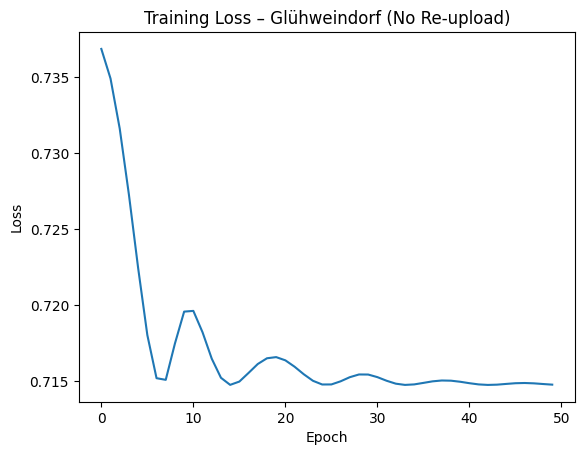

Train/Test accuracy: 0.7971428571428572 0.8


In [11]:
X_train, X_test, y_train, y_test = load_dataset("gluehweindorf.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

w_g, loss_g, circ_g = train_vqc_baseline(
    X_train, y_train_pm,
    entangle=True,
    stepsize=0.1,
    epochs=50
)

plt.plot(loss_g)
plt.title("Training Loss – Glühweindorf (No Re-upload)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print("Train/Test accuracy:",
      evaluate(circ_g, w_g, X_train, y_train)[0],
      evaluate(circ_g, w_g, X_test, y_test)[0])

The training loss for the baseline model on the Glühweindorf dataset decreases rapidly during the first epochs and then stabilizes, indicating successful convergence. Both training and test accuracy are high and very similar, which suggests that the dataset is relatively easy to classify and that the model generalizes well without overfitting.

## Lebkuchenstadt (baseline)

The approach for the Lebkuchenstadt is the same with the difference of parametrization. The model uses two qubits with angle encoding and a single variational layer, including entanglement via a CNOT gate. Training is performed using the Adam optimizer with a reduced learning rate of 0.05 and 60 epochs to allow more stable convergence on this noisier dataset.

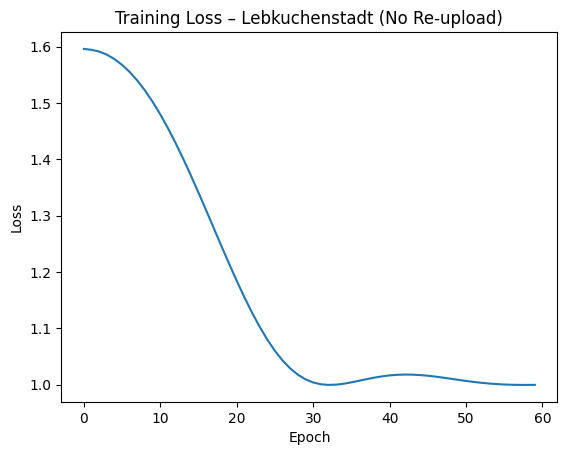

Train/Test accuracy: 0.5085714285714286 0.5


In [12]:
X_train, X_test, y_train, y_test = load_dataset("lebkuchenstadt.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

w_l, loss_l, circ_l = train_vqc_baseline(
    X_train, y_train_pm,
    entangle=True,
    stepsize=0.05,
    epochs=60
)

plt.plot(loss_l)
plt.title("Training Loss – Lebkuchenstadt (No Re-upload)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print("Train/Test accuracy:",
      evaluate(circ_l, w_l, X_train, y_train)[0],
      evaluate(circ_l, w_l, X_test, y_test)[0])

The training loss decreases steadily, indicating that the model is able to optimize its parameters. However, both training and test accuracy remain close to 0.5, which suggests that the baseline classifier struggles to generalize on the Lebkuchenstadt dataset due to noise and class overlap.

## Krampuskogel (baseline)

For the Krampuskogel dataset, the baseline variational quantum classifier is trained without entanglement and with a smaller learning rate of 0.02 over 80 epochs. This more conservative configuration is chosen due to the high noise and complexity of the dataset, aiming for stable optimization rather than aggressive fitting.

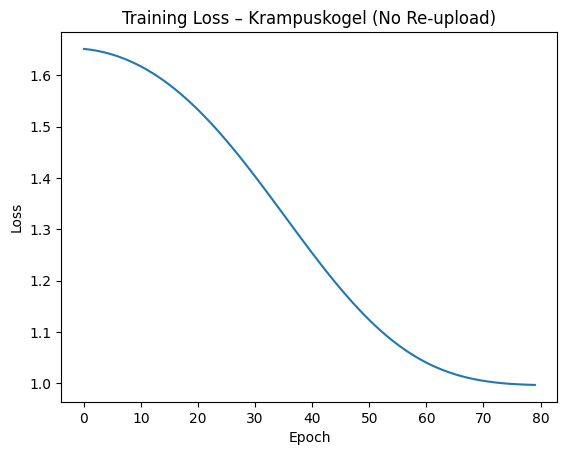

Train/Test accuracy: 0.5342857142857143 0.4266666666666667


In [13]:
X_train, X_test, y_train, y_test = load_dataset("krampuskogel.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

w_k, loss_k, circ_k = train_vqc_baseline(
    X_train, y_train_pm,
    entangle=False,
    stepsize=0.02,
    epochs=80
)

plt.plot(loss_k)
plt.title("Training Loss – Krampuskogel (No Re-upload)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print("Train/Test accuracy:",
      evaluate(circ_k, w_k, X_train, y_train)[0],
      evaluate(circ_k, w_k, X_test, y_test)[0])

The training loss decreases steadily over the epochs, which suggests stable optimization, but the test accuracy remains low and significantly below the training accuracy, indicating poor generalization. This confirms that the Krampuskogel dataset is highly challenging due to strong noise and class overlap, which limits the performance of the baseline classifier.

# DATA RE-UPLOADING

## VQC WITH data re-uploading

The `train_vqc_reupload` function implements a variational quantum classifier using data re-uploading. Unlike the baseline model, where the classical data is encoded only once, here we repeatedly encode the same input features into the quantum circuit. Each data encoding step is followed by an independent variational layer with its own trainable parameters.

The number of re-upload layers controls the depth and expressive power of the circuit. By increasing the number of layers, the model can represent more complex decision boundaries without increasing the number of qubits. Entanglement between qubits can optionally be enabled to further enhance expressivity and we used it here to set the same entaglement strategies for the models as in baseline classifiers.

The model is trained by minimizing a mean squared error loss between the circuit outputs and the target labels using the Adam optimizer. Training loss values are stored to analyze convergence behavior. This model is used to study the effect of data re-uploading compared to the baseline classifier.

In [36]:
def train_vqc_reupload(
    X_train, y_train,
    n_layers=3,
    entangle=True,
    n_qubits=2,
    stepsize=0.05,
    epochs=60
):
    # Create a quantum device with the specified number of qubits
    dev = qml.device("default.qubit", wires=n_qubits)

    # Encode classical input features into quantum rotations
    def encode(x):
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)

    # Variational layer with trainable parameters and optional entanglement
    def variational_layer(weights):
        # Apply parameterized rotations on each qubit
        for i in range(n_qubits):
            qml.RY(weights[i], wires=i)
        # Apply entangling gate if enabled
        if entangle:
            qml.CNOT(wires=[0, 1])

    # Define the quantum circuit with data re-uploading
    @qml.qnode(dev)
    def circuit(x, weights):
        # Repeatedly encode the same data and apply variational layers
        for l in range(n_layers):
            encode(x)  # Data re-uploading step
            variational_layer(weights[l])
        # Measure expectation value for binary classification
        return qml.expval(qml.PauliZ(0))

    # Loss function (mean squared error)
    # Uses continuous outputs for differentiability
    def loss(weights):
      preds = [circuit(x, weights) for x in X_train]
      return pnp.mean((pnp.array(preds) - y_train) ** 2)


    # Initialize trainable parameters for all re-upload layers
    weights = pnp.random.normal(
        0, 0.1, size=(n_layers, n_qubits), requires_grad=True
    )
    # Adam optimizer for training
    opt = qml.AdamOptimizer(stepsize=stepsize)

    # Store loss values for each training epoch
    losses = []
    for _ in range(epochs):
        weights, current_loss = opt.step_and_cost(loss, weights)
        losses.append(current_loss)

    return weights, losses, circuit

## Glühweindorf WITH re-upload

For the Glühweindorf dataset, the re-uploading variational quantum classifier uses the same configuration as the baseline model in terms of qubit count, entanglement strategy, optimizer, learning rate, and number of training epochs. The only difference is the application of data re-uploading, where the input data is encoded three times using three consecutive variational layers.

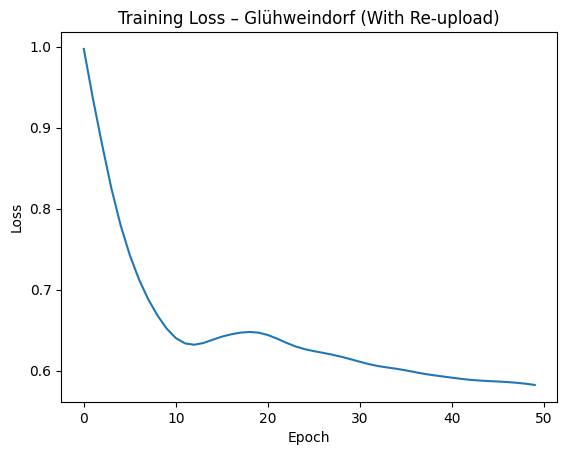

In [37]:
X_train, X_test, y_train, y_test = load_dataset("gluehweindorf.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

w_gr, loss_gr, circ_gr = train_vqc_reupload(
    X_train, y_train_pm,
    n_layers=3,
    entangle=True,
    stepsize=0.1,
    epochs=50
)

plt.plot(loss_gr)
plt.title("Training Loss – Glühweindorf (With Re-upload)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [38]:
train_acc_r, train_cm_r = evaluate(circ_gr, w_gr, X_train, y_train)
test_acc_r, test_cm_r   = evaluate(circ_gr, w_gr, X_test, y_test)

print("Train accuracy (re-upload):", train_acc_r)
print("Test accuracy  (re-upload):", test_acc_r)

Train accuracy (re-upload): 0.78
Test accuracy  (re-upload): 0.8266666666666667


With data re-uploading, the training loss decreases faster and reaches a lower value compared to the baseline model. Both training and test accuracy are high, with a slight improvement in test accuracy, indicating that data re-uploading helps the model better capture the structure of the Glühweindorf dataset without harming generalization.

In [25]:
def plot_confusion(cm, title):
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


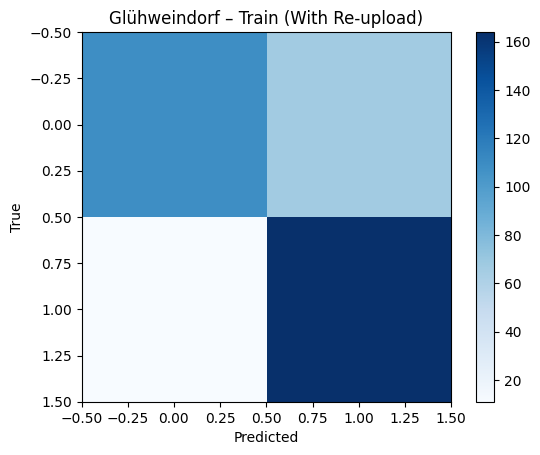

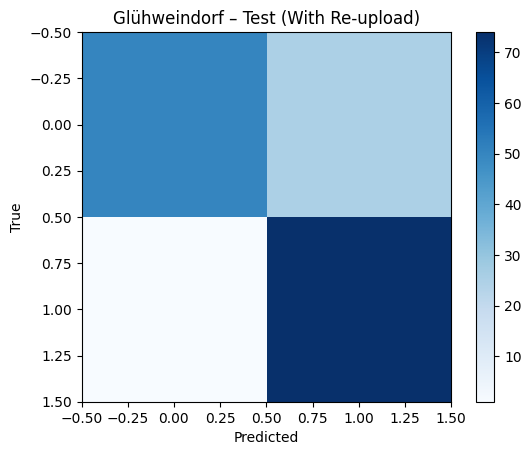

In [39]:
plot_confusion(train_cm_r, "Glühweindorf – Train (With Re-upload)")
plot_confusion(test_cm_r,  "Glühweindorf – Test (With Re-upload)")

The confusion matrices for the re-upload model on the Glühweindorf dataset show strong performance on both the training and test sets. Most predictions lie on the diagonal, indicating correct classification for both classes. Only a small number of misclassifications are present, which confirms that data re-uploading helps the model capture the underlying structure of the dataset while maintaining good generalization.

## Lebkuchenstadt WITH re-upload


For the Lebkuchenstadt dataset, the re-uploading variational quantum classifier uses the same settings as the baseline model and the only modification is the use of data re-uploading with four consecutive layers, which increases the circuit depth and expressive power while keeping all other hyperparameters unchanged.

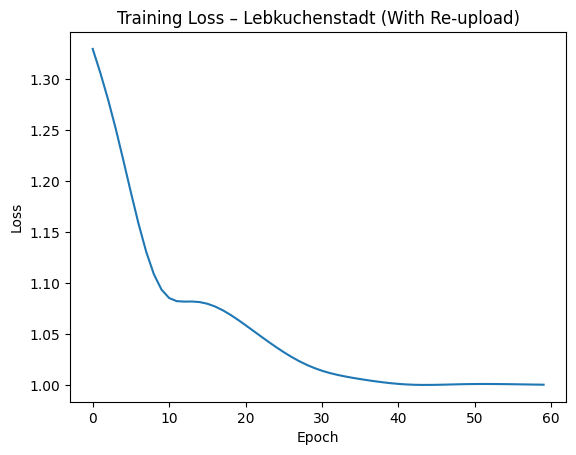

In [40]:
X_train, X_test, y_train, y_test = load_dataset("lebkuchenstadt.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

w_gr, loss_gr, circ_gr = train_vqc_reupload(
    X_train, y_train_pm,
    n_layers=4,
    entangle=True,
    stepsize=0.05,
    epochs=60
)

plt.plot(loss_gr)
plt.title("Training Loss – Lebkuchenstadt (With Re-upload)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [41]:
train_acc_r, train_cm_r = evaluate(circ_gr, w_gr, X_train, y_train)
test_acc_r, test_cm_r   = evaluate(circ_gr, w_gr, X_test, y_test)

print("Train accuracy (re-upload):", train_acc_r)
print("Test accuracy  (re-upload):", test_acc_r)

Train accuracy (re-upload): 0.5085714285714286
Test accuracy  (re-upload): 0.5266666666666666


With data re-uploading, the training loss decreases smoothly and converges to a lower value compared to the baseline model, but both training and test accuracy remain close to random guessing, indicating that the increased circuit depth improves optimization but does not significantly enhance classification performance on the noisy Lebkuchenstadt dataset.

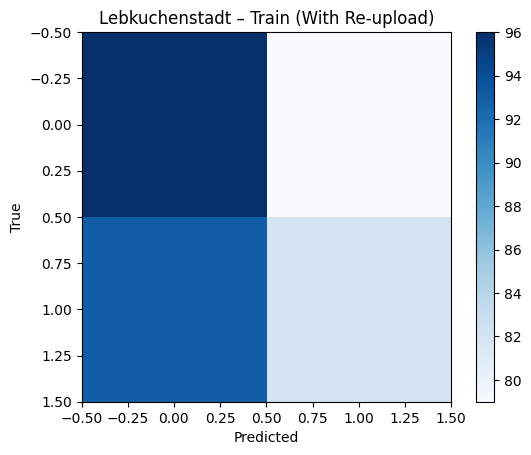

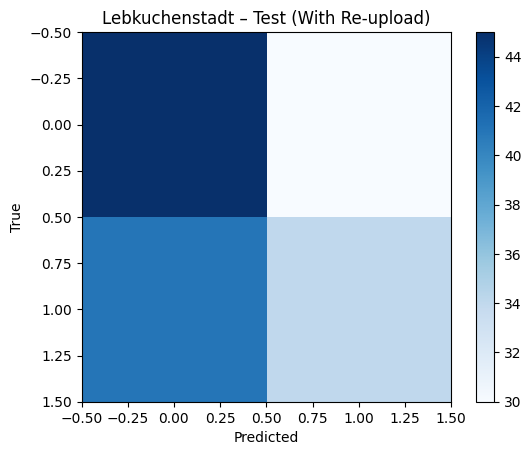

In [42]:
plot_confusion(train_cm_r, "Lebkuchenstadt – Train (With Re-upload)")
plot_confusion(test_cm_r,  "Lebkuchenstadt – Test (With Re-upload)")

The confusion matrices for the re-upload model show a large number of misclassifications for both classes. Predictions are biased toward one class, and many samples are incorrectly labeled, especially on the test set. This confirms that, despite improved training loss, the classifier struggles to generalize due to strong noise and class overlap in the dataset.

## Krampuskogel WITH re-upload

For the Krampuskogel dataset, we again use the same configuration as the baseline, with the only change being the application of data re-uploading using five layers to increase circuit depth while keeping all other hyperparameters unchanged.

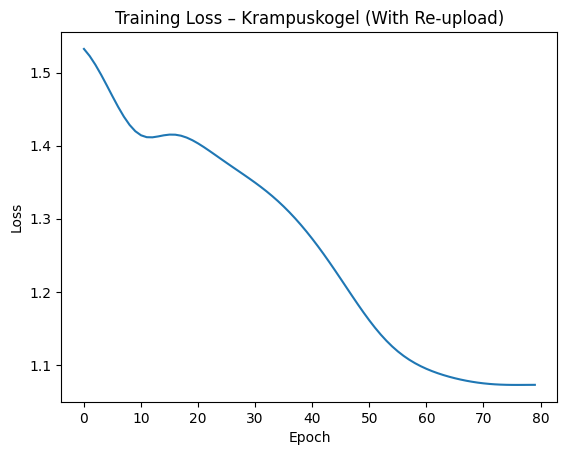

In [43]:
X_train, X_test, y_train, y_test = load_dataset("krampuskogel.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

w_gr, loss_gr, circ_gr = train_vqc_reupload(
    X_train, y_train_pm,
    n_layers=5,
    entangle=False,
    stepsize=0.02,
    epochs=80
)

plt.plot(loss_gr)
plt.title("Training Loss – Krampuskogel (With Re-upload)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [44]:
train_acc_r, train_cm_r = evaluate(circ_gr, w_gr, X_train, y_train)
test_acc_r, test_cm_r   = evaluate(circ_gr, w_gr, X_test, y_test)

print("Train accuracy (re-upload):", train_acc_r)
print("Test accuracy  (re-upload):", test_acc_r)

Train accuracy (re-upload): 0.4942857142857143
Test accuracy  (re-upload): 0.5


With data re-uploading, we once again observe taht the training loss decreases more smoothly compared to the baseline model. While the overall performance remains limited, the test accuracy increases from approximately 0.42 in the baseline case to around 0.50 with re-uploading, indicating a small but noticeable improvement. This suggests that increased circuit depth helps the model capture slightly more structure in the Krampuskogel dataset, although strong noise still limits generalization.

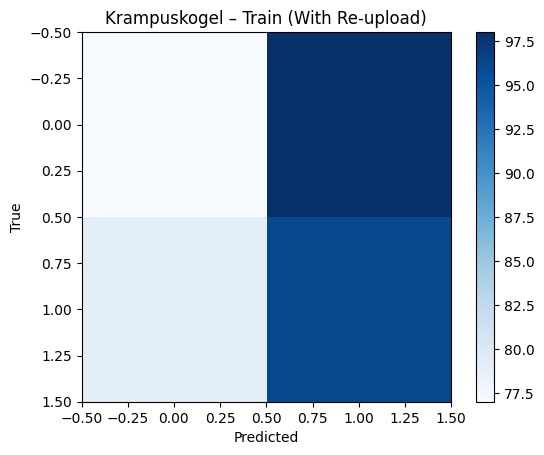

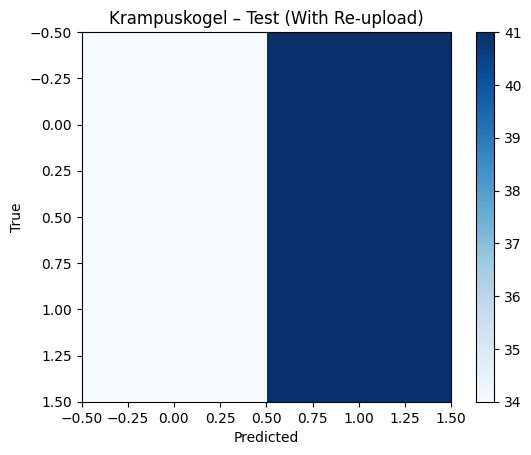

In [45]:
plot_confusion(train_cm_r, "Krampuskogel – Train (With Re-upload)")
plot_confusion(test_cm_r,  "Krampuskogel – Test (With Re-upload)")

The confusion matrices for the re-upload model on the Krampuskogel dataset show a strong bias toward predicting a single class, especially on the test set. Although data re-uploading slightly improves overall test accuracy compared to the baseline, the model still fails to reliably distinguish between the two classes. This strong bias toward predicting a single class in the Krampuskogel confusion matrices can be explained by the high amount of noise and strong overlap between the classes. Here the variational quantum classifier has difficulty learning a clear decision boundary and instead settles on a simpler solution that minimizes the loss by mostly predicting one class. Although data re-uploading increases the expressive power of the circuit, it is not sufficient to overcome the difficulty of the dataset. We also disabled entanglement and the lack of it and the limited model size further reduce the ability to capture complex relationships in the data, which results in poor generalization and unbalanced predictions.

# Discussion

For **Glühweindorf**, the baseline classifier already performs well, with high training and test accuracy. This indicates that the dataset is relatively clean and that the classes are easy to separate. When data re-uploading is applied, the training loss decreases faster and reaches a lower value, and the test accuracy improves slightly. The confusion matrices show that most predictions lie on the diagonal for both training and test data. This suggests that data re-uploading helps the model capture the structure of the dataset more effectively, although the improvement is limited because the baseline model is already sufficient.

The **Lebkuchenstadt** dataset is more challenging due to systematic noise and class overlap. In the baseline case, the training loss decreases, but both training and test accuracy remain close to random guessing. With data re-uploading, the training loss decreases more smoothly and converges faster, which indicates improved optimization and higher expressivity, but the training accuracy remains nearly unchanged and the improvement in test accuracy is small. The confusion matrices show many misclassifications and a bias toward one class. This demonstrates that while data re-uploading improves training behavior, the noisy nature of the dataset limits its effect on classification performance and generalization.

**Krampuskogel** is the most difficult dataset. Both baseline and re-upload models show decreasing training loss, but the test accuracy remains low. With data re-uploading, the test accuracy increases slightly compared to the baseline, but overall performance is still poor. The confusion matrices reveal a strong bias toward predicting a single class, especially on the test set. This behavior can be explained by the high level of noise and strong class overlap in the data. In such conditions, the classifier struggles to learn a meaningful decision boundary and instead converges to a simple strategy that minimizes the loss by favoring one class. Although data re-uploading increases circuit depth and expressivity, it cannot overcome the intrinsic difficulty of the dataset. The lack of entanglement and the limited model capacity further restrict the ability to model complex correlations.

Overall, our results show that data re-uploading consistently improves training dynamics and optimization stability, but it does not guarantee better generalization. Its benefits are most visible on cleaner datasets, while its impact is limited on highly noisy data. These findings highlight both the potential and the limitations of variational quantum classifiers and demonstrate that increased expressivity alone is not sufficient to handle strong noise and class overlap.